In [1]:
from google.colab import drive
drive.mount('/gdrive')
root='/gdrive/MyDrive/'

Mounted at /gdrive


# Data Overview

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.compose import ColumnTransformer
from sklearn import metrics
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
%matplotlib inline

In [3]:
pd.set_option('display.max_columns',None)  #to show all columns
dfimmo=pd.read_csv(root+"immo_data.csv",usecols=['serviceCharge', 'heatingType', 'telekomUploadSpeed', 'totalRent'])  #reading dataset

In [4]:
df = dfimmo.copy()

In [5]:
df.columns

Index(['serviceCharge', 'heatingType', 'telekomUploadSpeed', 'totalRent'], dtype='object')

In [9]:
df.head(5)

,serviceCharge,heatingType,telekomUploadSpeed,totalRent
0,245.00,central_heating,10.0,840.0
1,134.00,self_contained_central_heating,10.0,NaN
2,255.00,floor_heating,2.4,1300.0
3,58.15,district_heating,40.0,NaN
4,138.00,self_contained_central_heating,NaN,903.0


In [10]:
df.shape

(268850, 4)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268850 entries, 0 to 268849
Data columns (total 4 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   serviceCharge       261941 non-null  float64
 1   heatingType         223994 non-null  object 
 2   telekomUploadSpeed  235492 non-null  float64
 3   totalRent           228333 non-null  float64
dtypes: float64(3), object(1)
memory usage: 8.2+ MB


# Data Cleaning

In [12]:
print('NaN value percentage of each column:\n')
for col in df.columns:
    print(col,":\t", df[col].isnull().sum()/len(df[col])*100,"%")   #null percents

NaN value percentage of each column:

serviceCharge :	 2.5698344801934163 %
heatingType :	 16.68439650362656 %
telekomUploadSpeed :	 12.407662265203644 %
totalRent :	 15.070485400781106 %


**Filling NaN values**

In [13]:
df.serviceCharge.fillna(df.serviceCharge.median(), inplace=True)
df.heatingType.fillna(df.heatingType.mode()[0], inplace=True)
df.telekomUploadSpeed.fillna(df.telekomUploadSpeed.median(), inplace=True)
df.totalRent.fillna(df.totalRent.median(), inplace=True)

In [14]:
df.head(5)

,serviceCharge,heatingType,telekomUploadSpeed,totalRent
0,245.00,central_heating,10.0,840.0
1,134.00,self_contained_central_heating,10.0,650.0
2,255.00,floor_heating,2.4,1300.0
3,58.15,district_heating,40.0,650.0
4,138.00,self_contained_central_heating,40.0,903.0


In [15]:
df.describe()

,serviceCharge,telekomUploadSpeed,totalRent
count,268850.000000,268850.000000,2.688500e+05
mean,150.789643,30.193975,8.634546e+02
std,304.319451,15.729180,3.063164e+04
min,0.000000,1.000000,0.000000e+00
25%,96.000000,10.000000,4.950000e+02
50%,135.000000,40.000000,6.500000e+02
75%,185.000000,40.000000,9.000000e+02
max,146118.000000,100.000000,1.575154e+07


# Outliers

In [16]:
# Return unbiased kurtosis over requested axis using Fisher's definition of kurtosis (kurtosis of normal == 0.0).
# The result is normalized by N-1
kurt = df.kurt(numeric_only=True)[:]
kurt

serviceCharge         197151.674512
telekomUploadSpeed        -0.765917
totalRent             260044.391607
dtype: float64

In [17]:
outliers = ['serviceCharge', 'totalRent']

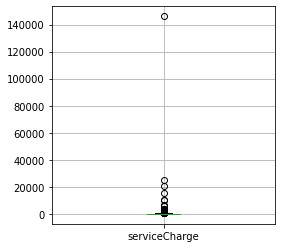

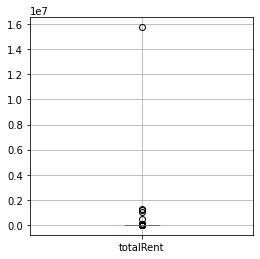

In [18]:
for col in outliers:
    plt.figure(figsize=(4, 4))
    df.boxplot(column=[col])

**Robust Scaler**

IQR = Q3 – Q1   

x scaled  = (x – Q1)/(Q3 – Q1)

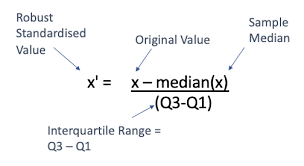

In [19]:
def outliers_iqr(ys):
    quartile_1, quartile_3 = np.percentile(ys, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    return np.where((ys > upper_bound) | (ys < lower_bound))

In [20]:
for col in outliers:
    print(f'{col}: {len(outliers_iqr(df[col])[0])}')

serviceCharge: 10271
totalRent: 20025


In [21]:
def outliers_z_score(ys):
    threshold = 3
    mean_y = np.mean(ys)
    stdev_y = np.std(ys)
    z_scores = [(y - mean_y) / stdev_y for y in ys]
    return np.where(np.abs(z_scores) > threshold)

In [22]:
for col in outliers:
    print(f'{col}: {len(outliers_z_score(df[col])[0])}')

serviceCharge: 98
totalRent: 6


deleting outliers

In [23]:
for i in outliers:
    quartile_1, quartile_3 = np.percentile(df[i], [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    df = df[df[i]<upper_bound]
    df = df[df[i]>lower_bound]

In [162]:
#for i in outliers:
#     mean_y = np.mean(df[i])
#     stdev_y = np.std(df[i])
#     lower_bound = mean_y - (3 * stdev_y)
#     upper_bound = mean_y + (3 * stdev_y)
#     df = df[df[i]<upper_bound]
#     df = df[df[i]>lower_bound]

# Feature engineering

In [24]:
df.heatingType.value_counts()

central_heating                   159389
district_heating                   22260
gas_heating                        18191
self_contained_central_heating     18058
floor_heating                      12100
oil_heating                         4642
heat_pump                           2175
combined_heat_and_power_plant       1519
night_storage_heater                1322
electric_heating                     871
wood_pellet_heating                  780
stove_heating                        335
solar_heating                        128
Name: heatingType, dtype: int64

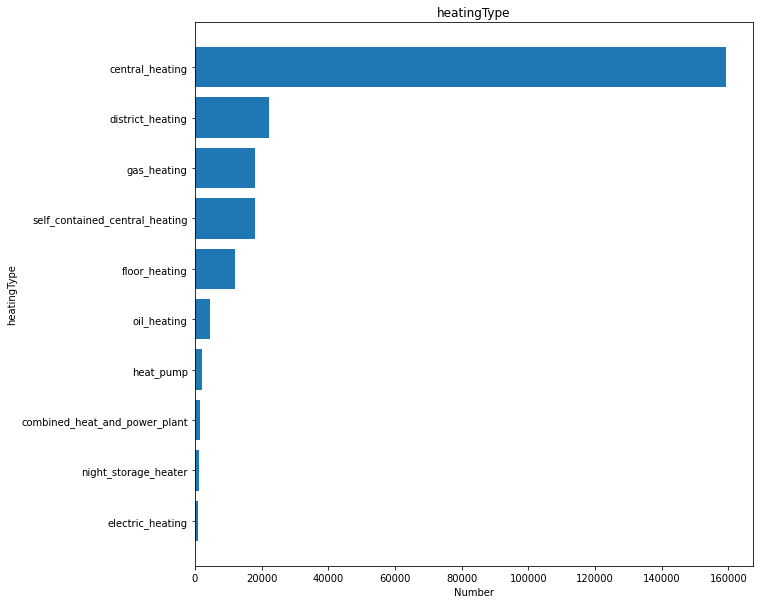

In [25]:
plt.figure(figsize=(10, 10))
data = df.heatingType.value_counts()[:10]
x = list(data.index)
y = list(data.values)
x.reverse()
y.reverse()

plt.title("heatingType")
plt.ylabel("heatingType")
plt.xlabel("Number")

plt.barh(x, y)
plt.show()

In [26]:
def filter(x):
    if x in [
    'oil_heating', 'combined_heat_and_power_plant', 'heat_pump', 'night_storage_heater', 
    'wood_pellet_heating', 'electric_heating', 'stove_heating', 'solar_heating'
] :
        x = 'other'
        return x
    else:
        return x
df.heatingType = df.heatingType.apply(filter)

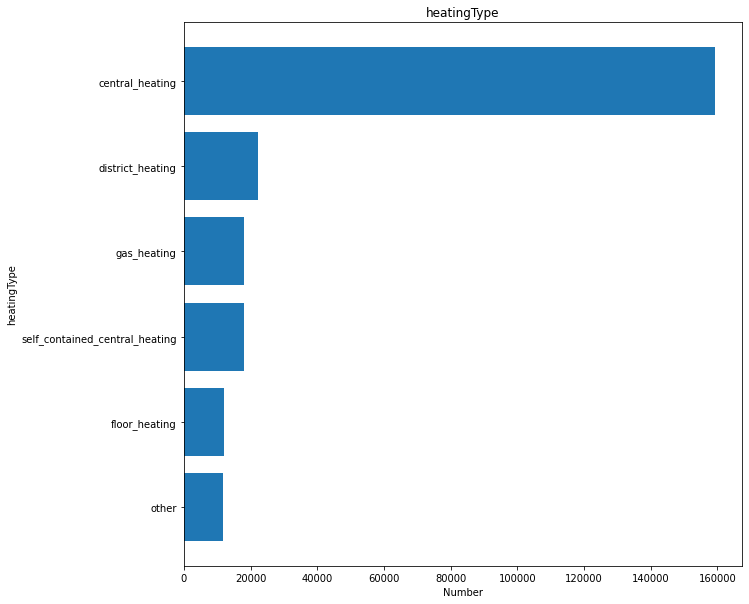

In [27]:
plt.figure(figsize=(10, 10))
data = df.heatingType.value_counts()[:10]
x = list(data.index)
y = list(data.values)
x.reverse()
y.reverse()

plt.title("heatingType")
plt.ylabel("heatingType")
plt.xlabel("Number")

plt.barh(x, y)
plt.show()

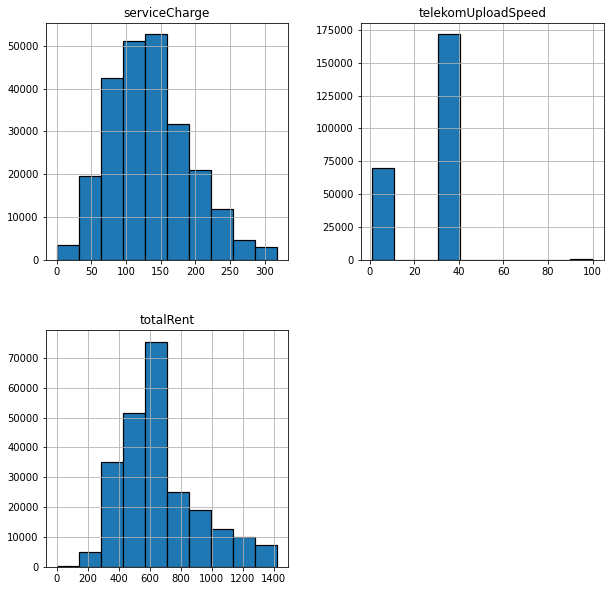

In [28]:
# Visualizing the distribution for every "feature"
df.hist(edgecolor="black", linewidth=1.2, figsize=(10, 10))
plt.show()

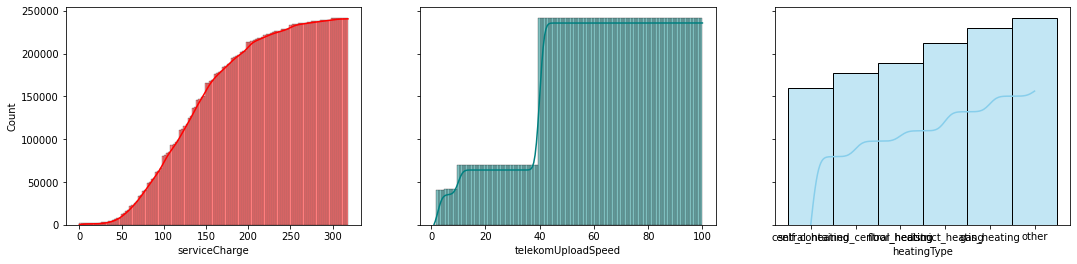

In [29]:
import matplotlib.pyplot as plt
# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
#sns.set(style="darkgrid")
fig, axs = plt.subplots(1,3, figsize=(18,4), sharey=True)

sns.histplot(data=df, x="serviceCharge", kde=True, color="red", ax=axs[0],stat='count', bins='auto',  
            discrete=None, cumulative=True, common_bins=True )
sns.histplot(data=df, x="telekomUploadSpeed", kde=True, color="teal", ax=axs[1],stat='count', bins='auto',  
            discrete=None, cumulative=True, common_bins=True)
sns.histplot(data=df, x="heatingType", kde=True, color="skyblue", ax=axs[2],stat='count', bins='auto',  
            discrete=None, cumulative=True, common_bins=True)

In [30]:
corr=df.corr()

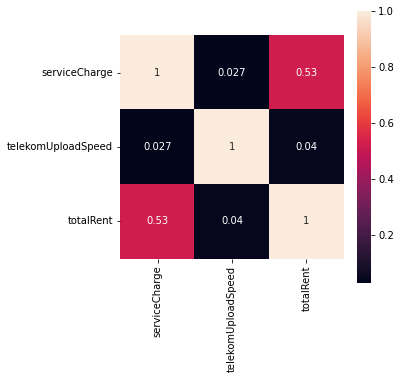

In [31]:
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(corr, square = True ,annot = True)

In [33]:
df_copy = df.copy()

In [34]:
df_copy['serviceCharge-2'] = df.serviceCharge ** 2
df_copy['telekomUploadSpeed-2'] = df.telekomUploadSpeed ** 2
df_copy['serviceCharge-3'] = df.serviceCharge ** 3
df_copy['telekomUploadSpeed-3'] = df.telekomUploadSpeed ** 3

In [35]:
corr2=df_copy.corr()

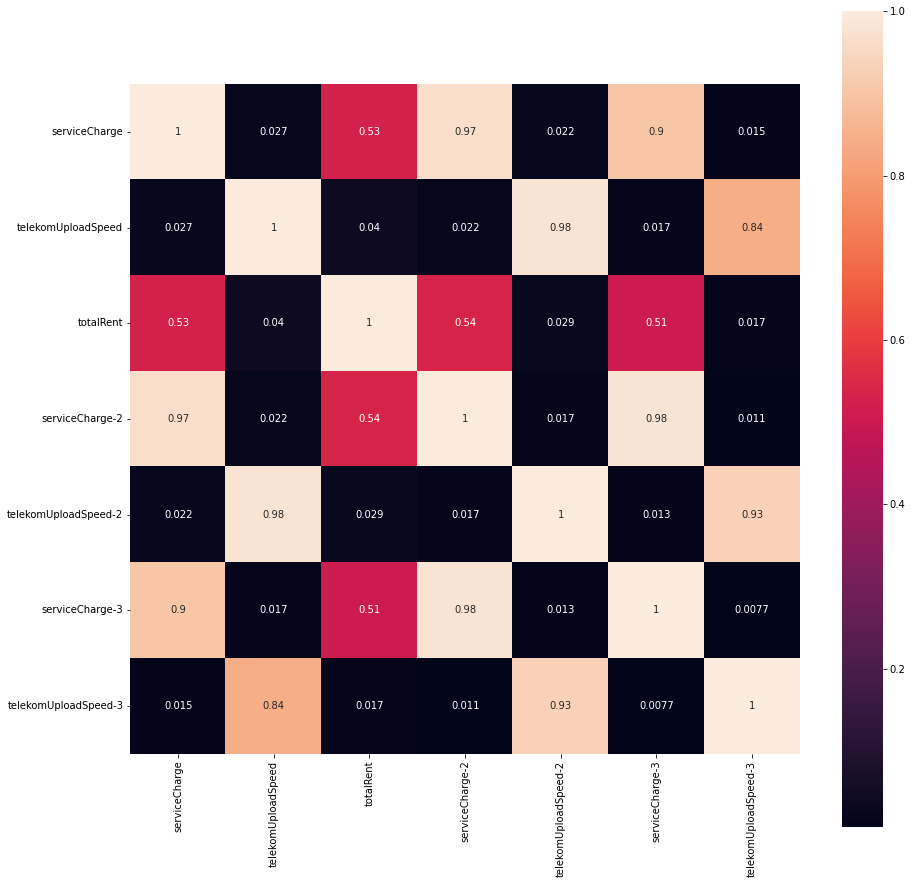

In [36]:
f,ax=plt.subplots(figsize=(15,15))
sns.heatmap(corr2, square = True ,annot = True)

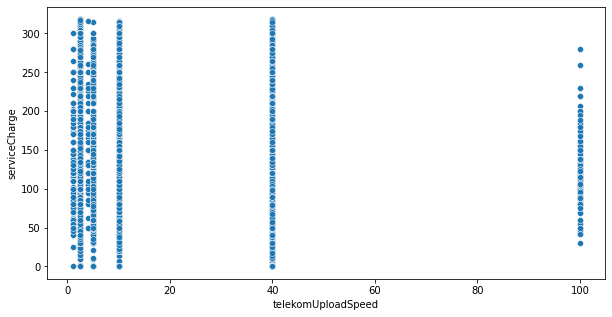

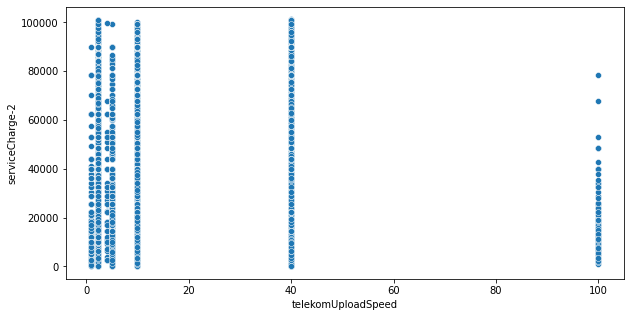

In [37]:
for col in ["serviceCharge", "serviceCharge-2"]:
    plt.figure(figsize=(10,5))
    sns.scatterplot(x="telekomUploadSpeed", y=col, data=df_copy)

In [38]:
df['serviceCharge'] = df.serviceCharge ** 2

# Preprocessing

In [39]:
df.columns

Index(['serviceCharge', 'heatingType', 'telekomUploadSpeed', 'totalRent'], dtype='object')

In [40]:
y = df.pop('totalRent')
X = df

In [41]:
X.columns

Index(['serviceCharge', 'heatingType', 'telekomUploadSpeed'], dtype='object')

In [42]:
y = pd.DataFrame(data=y, columns=['totalRent'])

In [43]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

y_train.head(3)

,totalRent
50775,390.00
208933,336.00
83899,217.53


In [44]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)   #onehot encoder
ss = StandardScaler()

In [45]:
preprocessor_x = ColumnTransformer(
    transformers=[
            ('serviceCharge', ss, ['serviceCharge']),
            ('telekomUploadSpeed', ss, ['telekomUploadSpeed']),
            ('heatingType', ohe, ['heatingType']),       
])
preprocessor_y = ColumnTransformer(
    transformers=[
            ('totalRent', ss, ['totalRent']),       
])


In [46]:
fitter_y = preprocessor_y.fit(y_train)
fitter_x = preprocessor_x.fit(X_train)

In [47]:
y_train = fitter_y.transform(y_train)
y_test = fitter_y.transform(y_test)
X_train = fitter_x.transform(X_train)
X_test = fitter_x.transform(X_test)

In [48]:
m, n = y_train.shape
x, z = y_test.shape
y_train = y_train.reshape(m, )
y_test = y_test.reshape(x, )

In [49]:
print(f'train x shape: {X_train.shape}')
print(f'train y shape: {y_train.shape}')
print(f'test x shape: {X_test.shape}')
print(f'test y shape: {y_test.shape}')

train x shape: (193416, 8)
train y shape: (193416,)
test x shape: (48354, 8)
test y shape: (48354,)


# Scratch

In [50]:
# Linear reggression
class Net() :   
    def __init__( self, learning_rate=0.01 , iterations=1000 , method='mse') :
        self.learning_rate = learning_rate
        self.iterations = iterations 
        self.method = method

    
    # Function for model training        
    def fit( self, X, Y ) : 
        # no_of_training_examples, no_of_features
        self.m, self.n = X.shape 
        # weight initialization 
        self.W = np.random.normal(loc=0.0, scale=0.001, size=self.n)
        self.b = 0 
        self.X = X
        self.Y = Y 
        # gradient descent learning         
        for i in range( self.iterations ) :
            self.update_weights(X, Y)  
        return self
    
    
    # Helper function to update weights in gradient descent 
    def update_weights( self, X, Y ) :
        Y_pred = self.predict( X )
        # calculate gradients
        
        # Linear reggression with minimum square error
        if self.method == 'mse':
            error = (Y - Y_pred)
            dW = - ( 2 * ( X.T ).dot( error )  ) / self.m
            db = - 2 * np.sum( error ) / self.m
    
            
        # Linear reggression with minimum absolute error
        elif self.method == 'ae':
            error = abs(Y - Y_pred)
            error = np.where(error == 0, 0.01, error)
            dW = ( np.sum( X.T, axis=1)/ 4)
            print(dW.shape)
            db = np.sum( error ) / 4
        
        # Linear reggression with Epsilon Sensitive Error
        elif self.method == 'ese':
            threshold = 0.00001
            error = abs(Y - Y_pred)
            error = np.where(error < threshold, 0.01, error)
            dW = ( ( X.T ).dot( error )  )
            db = np.sum( error ) 
        
        self.W = self.W - self.learning_rate * dW
        self.b = self.b - self.learning_rate * db 
        return self
    
    # Hypothetical function  h( x )  
    def predict( self, X ) :
        return (X.dot( self.W ) + self.b)

# Linear reggression with minimum square error

In [51]:
model_mse = Net(method='mse')

In [52]:
model_mse.fit(X_train, y_train)

In [53]:
print(model_mse.W)
print(model_mse.b)
y_pre_test_mse = model_mse.predict(X_test)
print('linear reggression from scrach (MSE) R^2: test', metrics.r2_score(y_test, y_pre_test_mse))

[ 0.52071975  0.02735513 -0.19859947 -0.17100586  0.37834894 -0.01623345
  0.10697415  0.01896497]
0.12108049319616136
linear reggression from scrach (MSE) R^2: test 0.32308239772313085


# MSE whithot package

Steps to find the MSE

Find the equation for the regression line.
(1)    \begin{equation*}   \hat{Y}_i = \hat{\beta}_0 + \hat{\beta}_1 X_i + \hat{\epsilon}_i   \end{equation*} 

Insert X values in the equation found in step 1 in order to get the respective Y values i.e.
(2)  \begin{equation*} \hat{Y}_i \end{equation*}  

Now subtract the new Y values (i.e. \hat{Y}_i) from the original Y values. Thus, found values are the error terms. It is also known as the vertical distance of the given point from the regression line.
(3)   \begin{equation*}  Y_i - \hat{Y}_i  \end{equation*} 

Square the errors found in step 3.
(4)   \begin{equation*}  {(Y_i - \hat{Y}_i)}^2  \end{equation*} 

Sum up all the squares.

  \begin{equation*}  \sum_{i=1}^{N}(Y_i - \hat{Y}_i)^2  \end{equation*} 
Divide the value found in step 5 by the total number of observations.
(6)   \begin{equation*}  MSE = \frac{1}{N}\sum_{i=1}^{N}(Y_i - \hat{Y}_i)^2  \end{equation*} 

steps:
1. define variable to store the sum of differences
2. finding total number of items in list
3. looping through each element of the list
4. finding the difference between observed and predicted value
5. taking square of the differene 
6. taking a sum of all the differences
7. dividing summation by total values to obtain average

In [54]:
y1 = X_train
y_bar =  y_train
sum = 0       
n = len(y1)
for i in range (0,n):  
  difference = y1[i] - y_bar[i]   
  squared_difference = difference**2  
  sum = sum + squared_difference  
MSE = sum/n  
print("The Mean Square Error is: " , MSE)

The Mean Square Error is:  [0.92930832 1.91846616 1.77658821 1.11589228 0.95136464 1.05678248
 1.01253114 1.08684125]


# Absolute Error whitout package

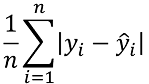

In [55]:
y2 = X_train
y_hat =  y_train
sum = 0       
n = len(y2)
for i in range (0,n):  
  difference = y2[i] - y_hat[i]   
  squared_difference = np.abs(difference )
  sum = sum + squared_difference  
AE = sum/n  
print("The Absolute Error is: " , AE)

The Absolute Error is:  [0.71265947 1.16942909 1.13325513 0.81149987 0.74558061 0.78690137
 0.76787735 0.80419836]


# Sklearn pakage

# LinearRegression

In [56]:
model_lr = LinearRegression()

In [57]:
model_lr.fit(X_train, y_train)

LinearRegression()

In [58]:
y_pred_test = model_lr.predict(X_test)

In [59]:
model_lr.coef_

array([ 0.51395341,  0.02647254, -0.24155738, -0.26543424,  0.52846628,
       -0.08534544,  0.10260838, -0.0387376 ])

In [60]:
print('linear reggression score train:', model_lr.score(X_train, y_train))
print('linear reggression R^2: test', metrics.r2_score(y_test, y_pred_test))

linear reggression score train: 0.3209083319148923
linear reggression R^2: test 0.3245789506734953


# Ridge

In [61]:
model_ridge = Ridge(alpha=1)

In [62]:
model_ridge.fit(X_train, y_train)

Ridge(alpha=1)

In [63]:
y_pred_test_ridge = model_ridge.predict(X_test)

In [64]:
model_ridge.coef_

array([ 0.51395253,  0.0264727 , -0.24154884, -0.26541266,  0.52841866,
       -0.08533284,  0.10260431, -0.03872862])

In [65]:
print('ridge reggression score train:', model_ridge.score(X_train, y_train))
print('ridge reggression R^2: test', metrics.r2_score(y_test, y_pred_test_ridge))

ridge reggression score train: 0.32090833173270017
ridge reggression R^2: test 0.324579149990356


# Lasso

In [66]:
model_lasso = Lasso(alpha=0.1)

In [67]:
model_lasso.fit(X_train, y_train)

Lasso(alpha=0.1)

In [68]:
y_pred_test_lasso = model_lasso.predict(X_test)

In [69]:
model_lasso.coef_

array([ 0.43534584,  0.        , -0.        , -0.        ,  0.        ,
        0.        ,  0.        ,  0.        ])

In [70]:
print('lasso reggression score train:', model_lasso.score(X_train, y_train))
print('lasso reggression R^2: test', metrics.r2_score(y_test, y_pred_test_lasso))

lasso reggression score train: 0.2765951683582323
lasso reggression R^2: test 0.2812011973379386


# Just servicecharge

In [71]:
X2 = X['serviceCharge']

In [72]:
y = pd.DataFrame(data=y, columns=['totalRent'])
X2 = pd.DataFrame(data=X2, columns=['serviceCharge'])

In [73]:
X_train2,X_test2,y_train2,y_test2 = train_test_split(X2,y,test_size=0.2)
ss = StandardScaler()
preprocessor_x2 = ColumnTransformer(
    transformers=[
            ('serviceCharge', ss, ['serviceCharge']),
])
preprocessor_y2 = ColumnTransformer(
    transformers=[
            ('totalRent', ss, ['totalRent']),       
])
fitter_y2 = preprocessor_y2.fit(y_train2)
fitter_x2 = preprocessor_x2.fit(X_train2)
y_train2 = fitter_y2.transform(y_train2)
y_test2 = fitter_y2.transform(y_test2)
X_train2 = fitter_x2.transform(X_train2)
X_test2 = fitter_x2.transform(X_test2)

In [74]:
model_lr_ser = LinearRegression()

In [75]:
model_lr_ser.fit(X_train2, y_train2)

LinearRegression()

In [76]:
y_pred_test2 = model_lr_ser.predict(X_test2)

In [77]:
model_lr_ser.coef_

array([[0.53613911]])

In [78]:
print('linear reggression serviceCharge score train:', model_lr_ser.score(X_train2, y_train2))
print('linear reggression serviceCharge R^2: test', metrics.r2_score(y_test2, y_pred_test2))

linear reggression serviceCharge score train: 0.2874451406558619
linear reggression serviceCharge R^2: test 0.28793048050113523


# DecisionTreeRegressor

In [79]:
tree = DecisionTreeRegressor()

In [80]:
tree.fit(X_train, y_train)

DecisionTreeRegressor()

In [81]:
y_pred_tree = tree.predict(X_test)

In [82]:
print('DecisionTreeRegressor: train', tree.score(X_train, y_train))
print('DecisionTreeRegressor R^2: test', metrics.r2_score(y_test, y_pred_tree))

DecisionTreeRegressor: train 0.44162459445130076
DecisionTreeRegressor R^2: test 0.34687859595220993
